In [1]:
import os
import sys

current_working_directory = os.getcwd()
utils_path = os.path.abspath(os.path.join(current_working_directory, '../utils'))
plotting_path = os.path.abspath(os.path.join(current_working_directory, '../plotting_templates/'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

In [2]:
import jax
jax.config.update("jax_enable_x64", True) # Enable 64-bit double precision

# Imports
import jax.numpy as jnp
from jax.numpy import fft
from jax import random, vmap, jit, grad
import jax.scipy as scipy
from scipy import integrate

import matplotlib.pyplot as plt
import time
from tqdm import tqdm

from jax import jit, grad, vmap, hessian, value_and_grad
import optax

from utils_DST import discrete_sine_transform, compute_sine_coefficients
from utils_error import compute_1d_error

In [3]:
plt.style.use(plotting_path + '/plot_style-Examples.txt')
width = 4
height = width * 3 / 4

# Solving a 1d Linear elliptic PDE with a neural network
This notebook shows the computation of a 1D Linear elliptic PDE with rough forcing using a NeS-PINN (section 4.2.1).

In [4]:
# Define a simple neural network
def init_params(layer_sizes, key):
    params = []
    keys = random.split(key, len(layer_sizes))
    for m, n, key in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        weights = random.normal(key, (m, n)) * jnp.sqrt(2 / m)
        biases = jnp.zeros(n)
        params.append((weights, biases))
    return params

# Draw random samples for the RF part
n_samples = 24
d_in = 1
key = random.PRNGKey(0)
key, subkey = random.split(key)
sigma_rff = 5.0
random_features = random.normal(subkey, shape = (n_samples, d_in))*sigma_rff

def feature_map(x, random_features):
    n_samples = random_features.shape[0]
    outputs = jnp.dot(random_features, x)
    return jnp.squeeze((1/jnp.sqrt(n_samples))*jnp.vstack([jnp.cos(outputs), jnp.sin(outputs)]))

def predict(params, x):
    activations = x
    # First pass through the feature map
    activations = feature_map(activations, random_features)
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

def count_parameters(params):
    total_params = 0
    for weights, biases in params:
        total_params += weights.size
        total_params += biases.size
    return total_params

## Using the DST for solving an elliptic PDE

We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\nu\Delta u + b(x)u &= \xi \\
u &= 0
\end{aligned}
with $b(x) = 1$.

If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2} + 1\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Conversely, if 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty \xi_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

then 

$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)} \sin\Big(\frac{n\pi x}{L}\Big)
$$

Our domain will be $[0,1]$ and so $L = 1.0$. Therefore

\begin{aligned}
\xi &=   \sqrt{2} \sum_{i}^\infty \xi_i \sin\Big(n\pi x\Big) \\
u &=  \sqrt{2}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)}\sin\Big(n\pi x\Big)
\end{aligned}

Our solution will be found using a NN.


In [5]:
# Generate a solution and forcing term
key = random.PRNGKey(635)
nu = 0.01


n_coef = 2**14
upper = 1.0
lower = 0.0
boundary = jnp.array([lower, upper])
boundary_conditions = jnp.array([0.0, 0.0])

domain_finest = jnp.linspace(lower,upper,n_coef+1, endpoint=False)[1:] # Do not include 0 or 1!
print("We use {} basis functions for the solution and the forcing term".format(n_coef))

frequencies = jnp.arange(0, n_coef) + 1
coef_f = jnp.hstack([random.normal(key, shape= (n_coef,))])
coef_u = coef_f/(nu*frequencies**2*jnp.pi**2 + 1)

f_values = discrete_sine_transform(coef_f)
u_values = discrete_sine_transform(coef_u)

We use 16384 basis functions for the solution and the forcing term


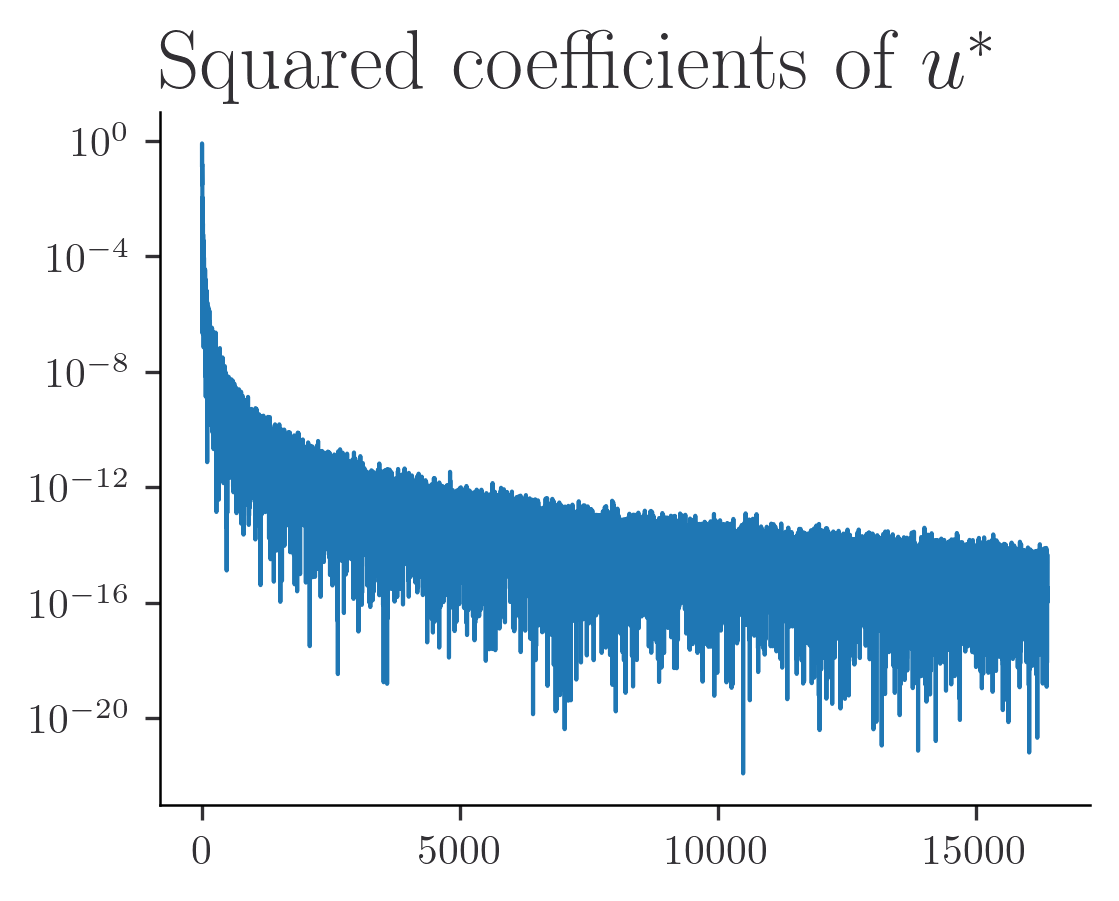

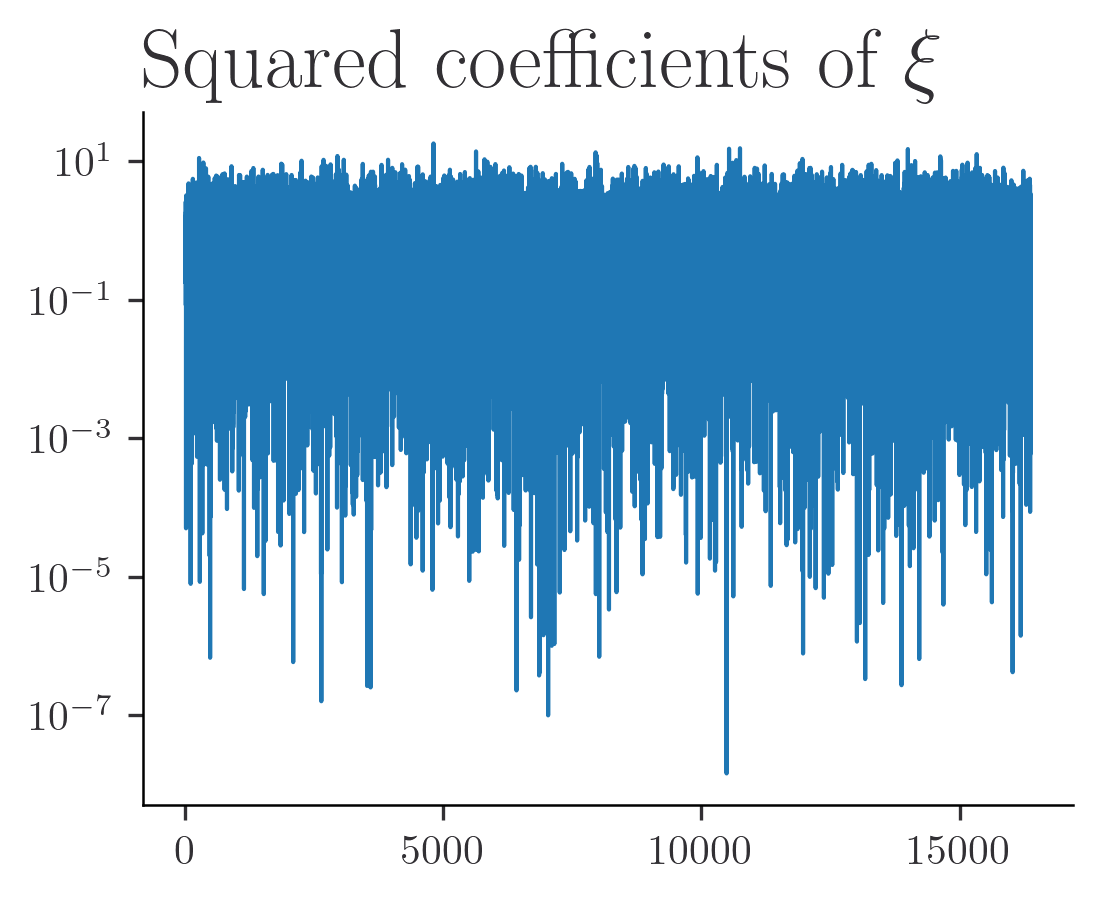

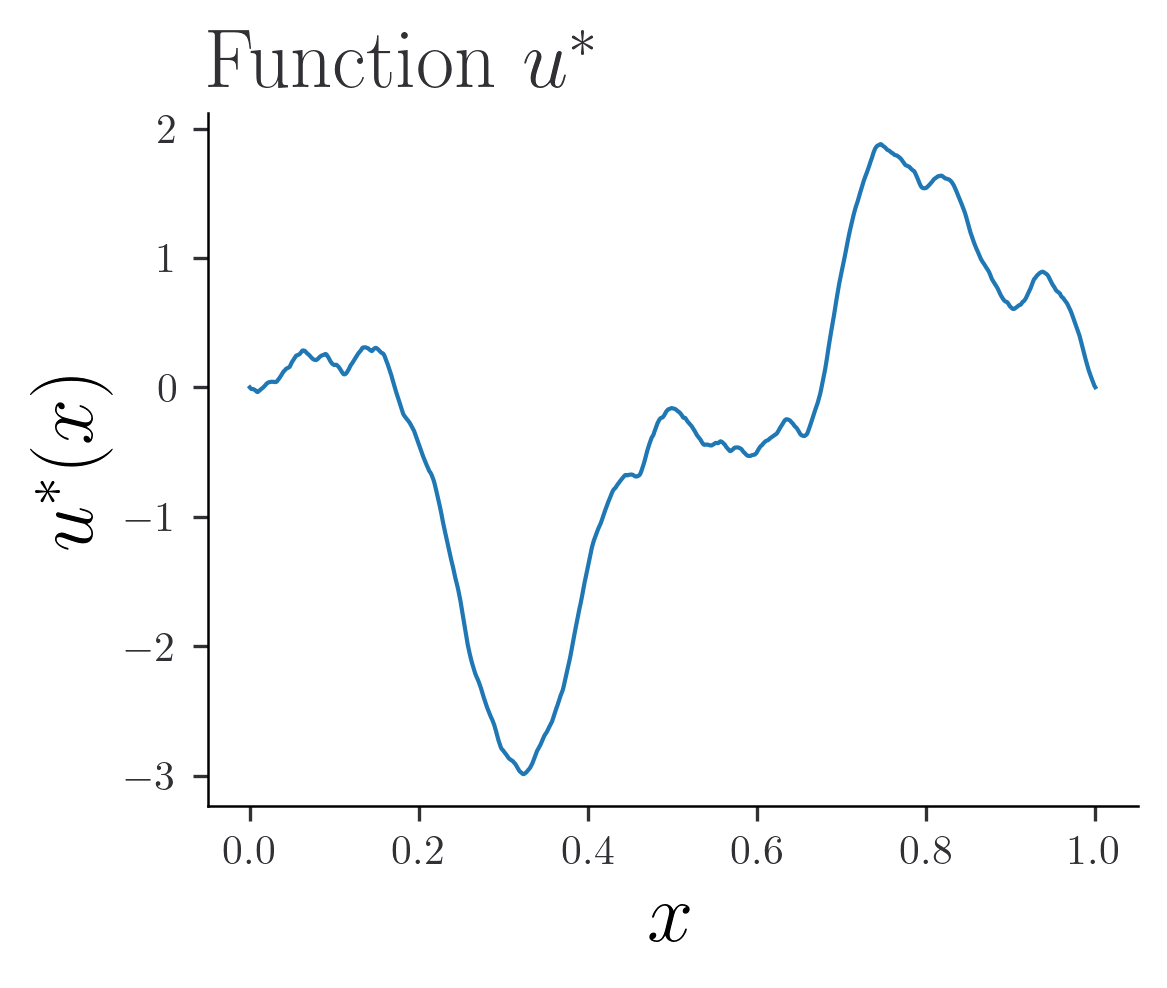

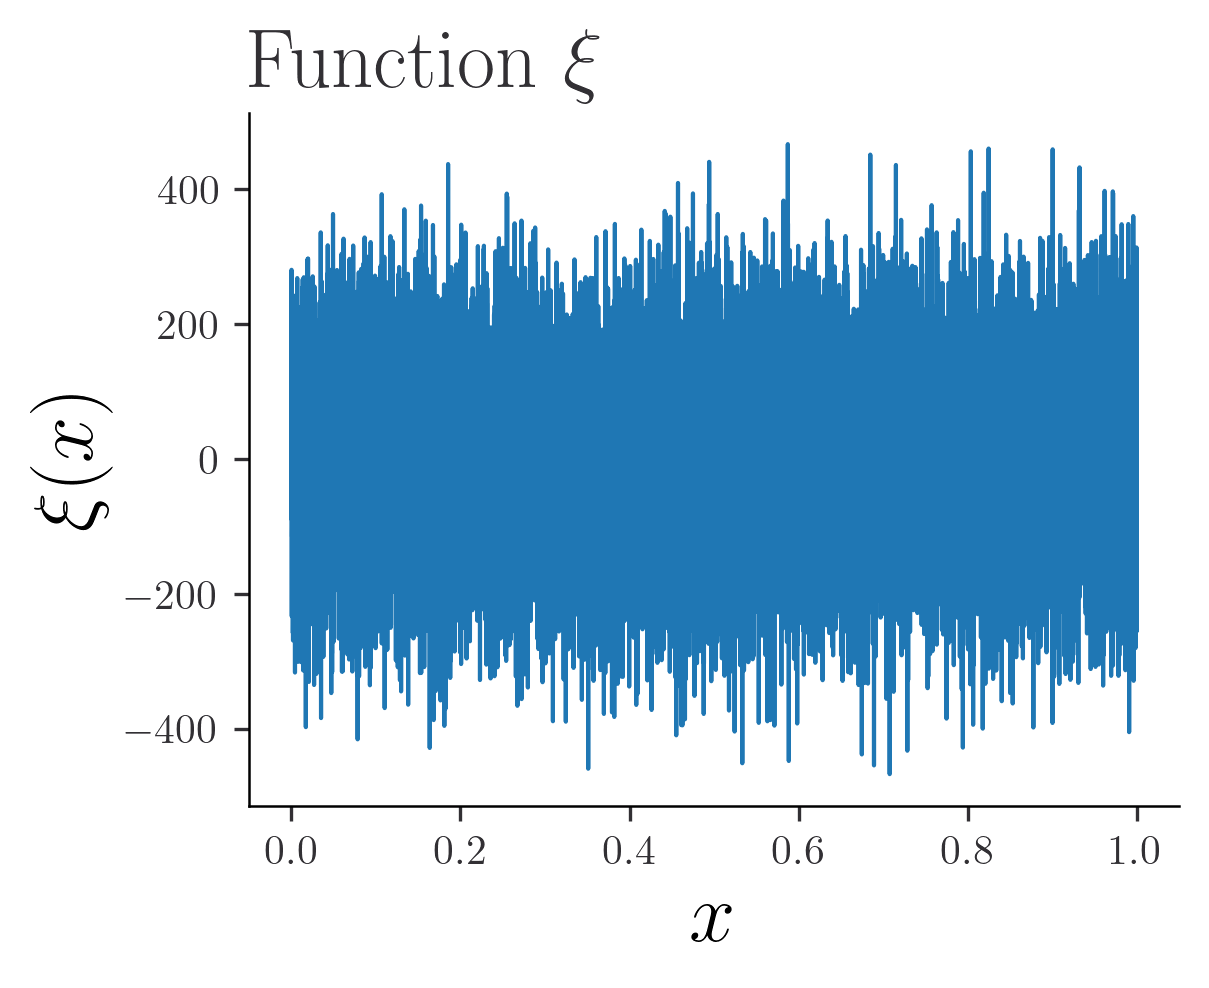

In [6]:
# Plot both the coeffients of u and f in 2 subplots
fig = plt.figure(figsize=(width, height))
plt.plot(coef_u**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $u^*$')
plt.show()

fig = plt.figure(figsize=(width, height))
plt.plot(coef_f**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $\xi$')
plt.show()

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, u_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$u^*(x)$")
plt.title(r"Function $u^*$")

fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, f_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$\xi(x)$")
plt.title(r"Function $\xi$")

plt.gca().autoscale() 
plt.show()

## Computing a solution using a negative Sobolev norm $H^{-1}$ loss 

In [7]:
n_meas = 2**12
print("We use {} test functions".format(n_meas))
domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!
f_observed =  coef_f[:n_meas]

We use 4096 test functions


In [8]:
s = 1.0 # Which negative Sobolev norm to use (s parameter in the paper)
decay = jnp.arange(1, n_meas+1)**(-s/2)

# Initialize the neural network
layer_sizes = [n_samples*2, 16, 16,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))
neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = compute_sine_coefficients(-nu*laplacian_grid + u_grid)
    residual_interior = (pred_sine - f)*decay

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)
loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu)

There are 1073 parameters in the neural network.


In [9]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [10]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

Epoch 0, Loss: 0.0143345
Step 0, Training Loss: 0.0143345, Learning Rate: 0.001000
Epoch 10000, Loss: 0.0012347
Step 10000, Training Loss: 0.0012347, Learning Rate: 0.000900
Epoch 20000, Loss: 0.0011644
Step 20000, Training Loss: 0.0011644, Learning Rate: 0.000810
Epoch 30000, Loss: 0.0011284
Step 30000, Training Loss: 0.0011284, Learning Rate: 0.000729
Epoch 40000, Loss: 0.0010986
Step 40000, Training Loss: 0.0010986, Learning Rate: 0.000656
Epoch 50000, Loss: 0.0010661
Step 50000, Training Loss: 0.0010661, Learning Rate: 0.000590
Epoch 60000, Loss: 0.0010319
Step 60000, Training Loss: 0.0010319, Learning Rate: 0.000531
Epoch 70000, Loss: 0.0010129
Step 70000, Training Loss: 0.0010129, Learning Rate: 0.000478
Epoch 80000, Loss: 0.0009771
Step 80000, Training Loss: 0.0009771, Learning Rate: 0.000430
Epoch 90000, Loss: 0.0009393
Step 90000, Training Loss: 0.0009393, Learning Rate: 0.000387


In [11]:
pred = neural_network(params, domain_finest)
e, e_rel = compute_1d_error(pred, u_values, domain_finest, domain_measurements)
print("The L^2 error is {:.2e}. The relative L^2 error is {:.2e}".format(e, e_rel))

The L^2 error is 2.49e-02. The relative L^2 error is 2.00e-02


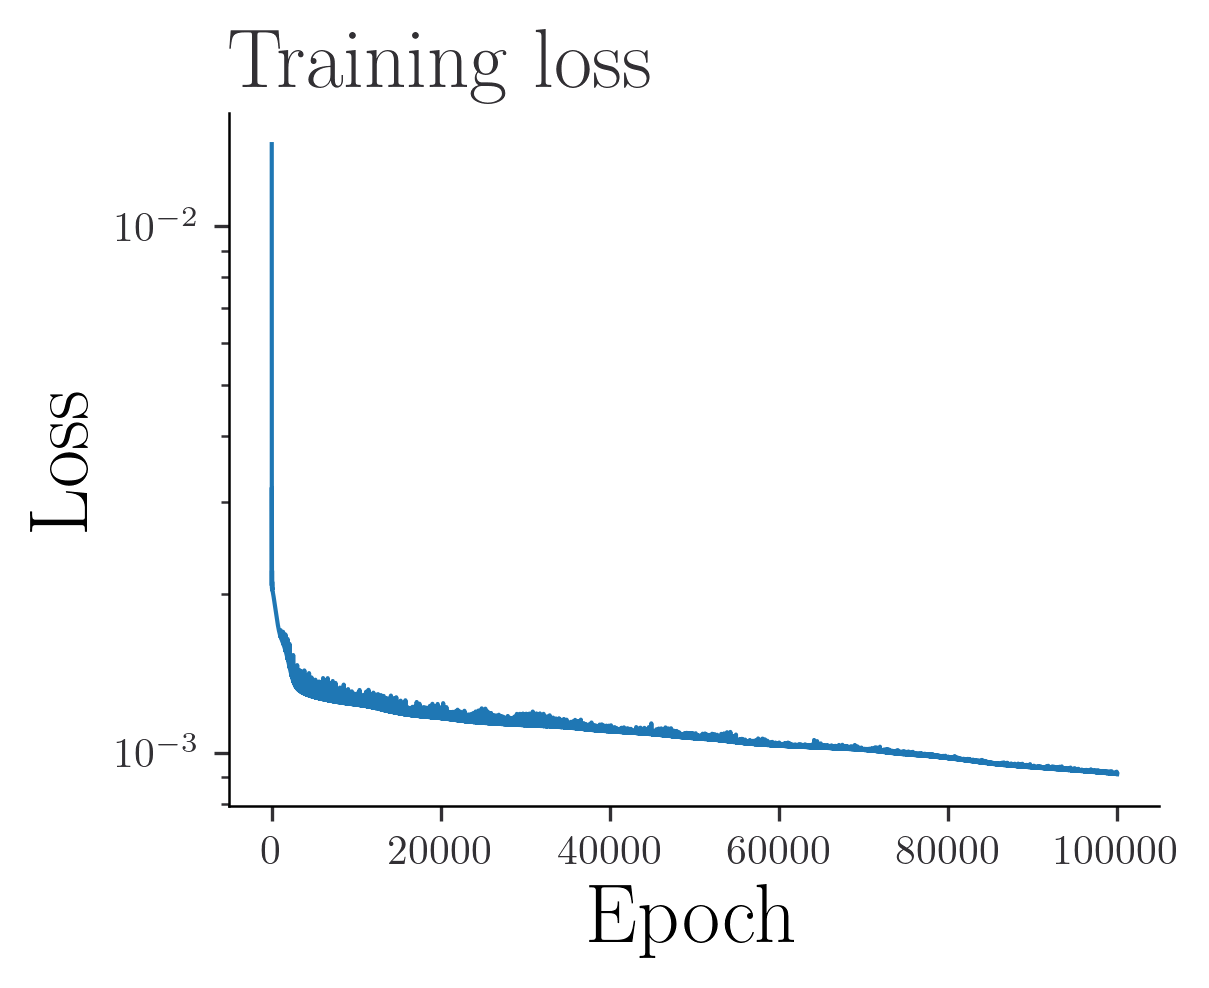

In [12]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

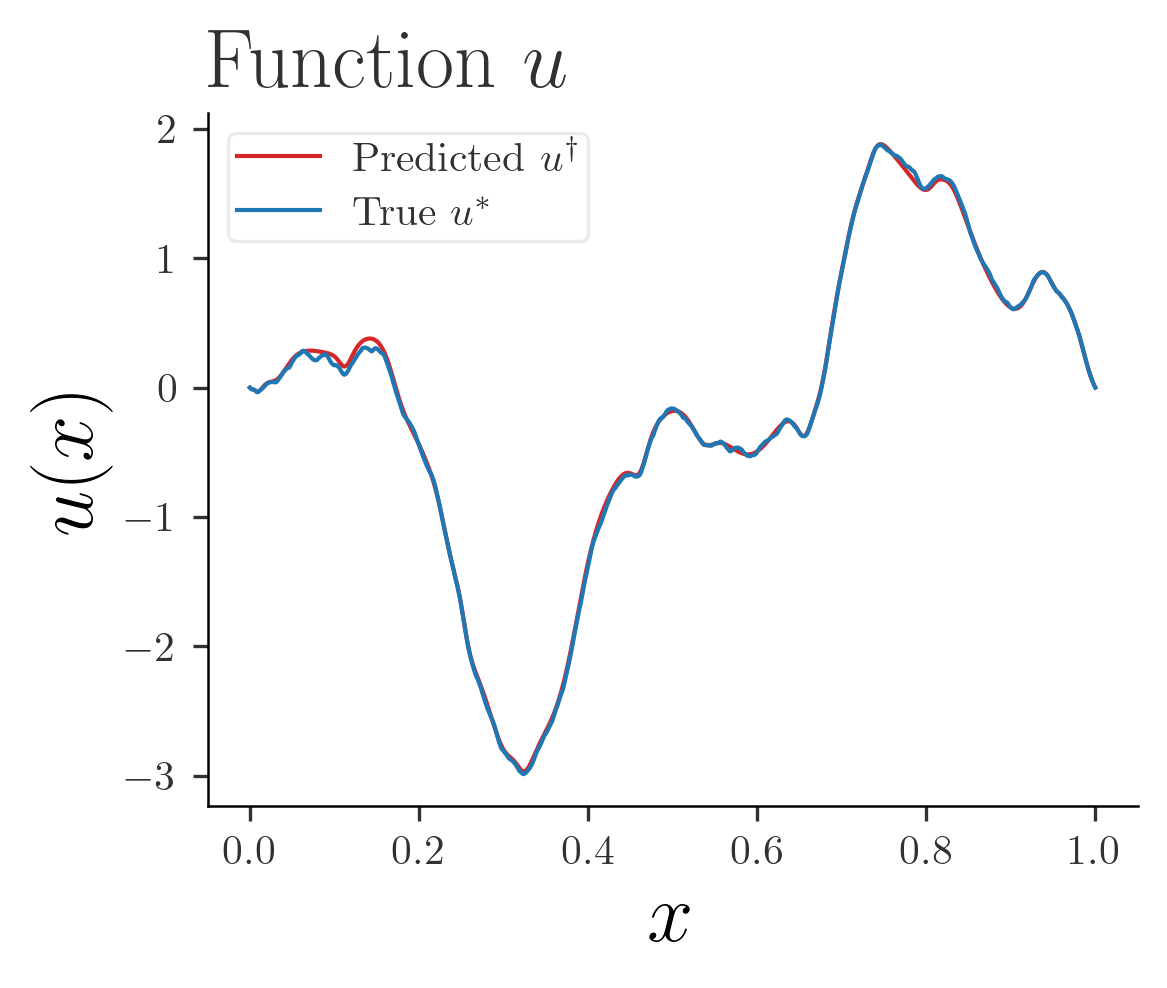

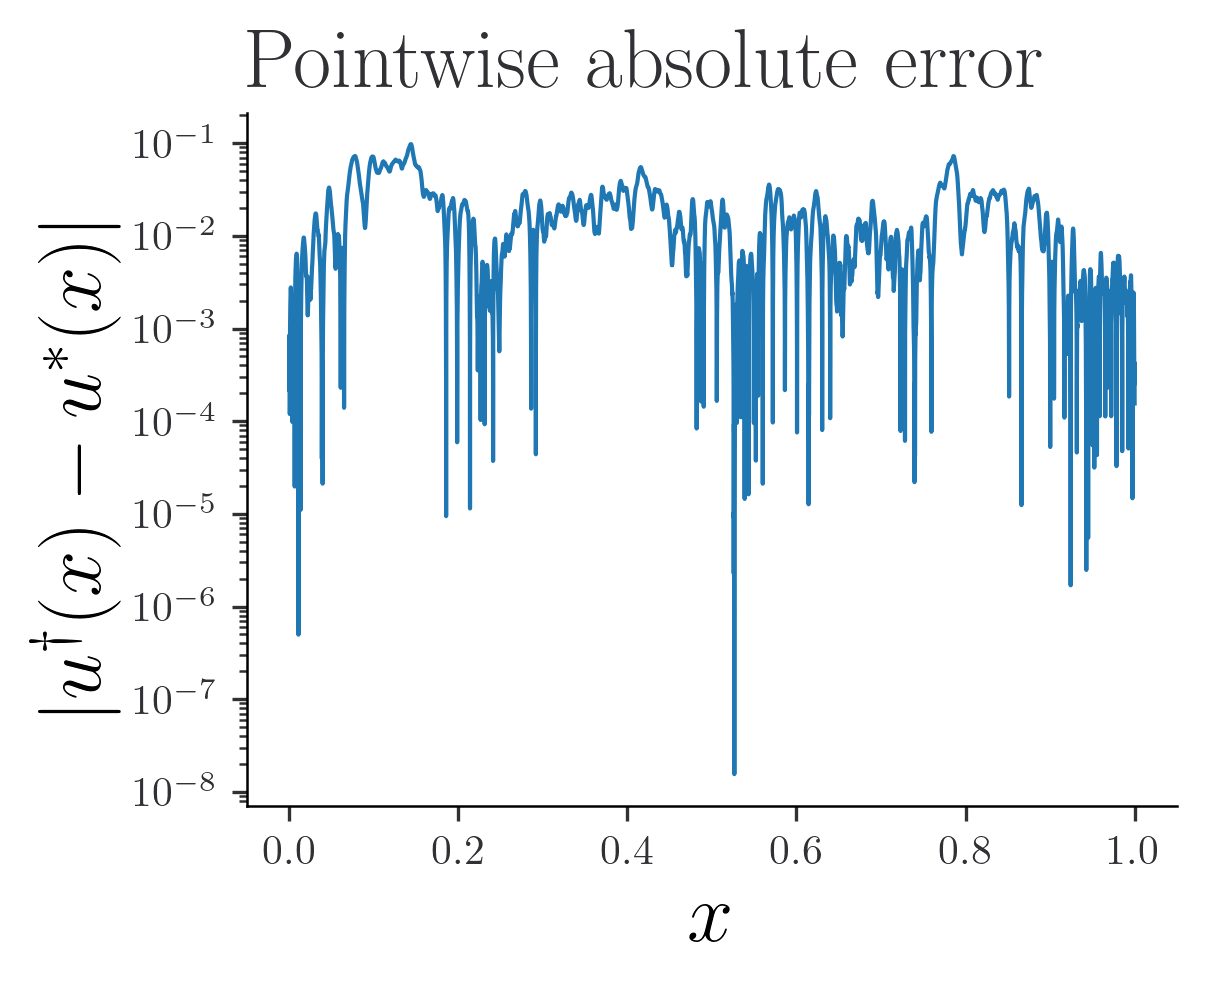

In [13]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


## Computing a solution using a pointwise loss

See https://arxiv.org/abs/2308.08468 for a description of this methodology.

In [14]:
ratio = int(n_coef/n_meas)
f_observed =  f_values[::ratio]

In [15]:
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))
neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))
# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred =-nu*laplacian_grid + u_grid
    residual_interior = (pred - f)

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu)

There are 1073 parameters in the neural network.


In [16]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [17]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

Epoch 0, Loss: 16565.5304545
Step 0, Training Loss: 16565.5304545, Learning Rate: 0.001000
Epoch 10000, Loss: 15710.6320502
Step 10000, Training Loss: 15710.6320502, Learning Rate: 0.000900
Epoch 20000, Loss: 15579.6102987
Step 20000, Training Loss: 15579.6102987, Learning Rate: 0.000810
Epoch 30000, Loss: 15479.0202583
Step 30000, Training Loss: 15479.0202583, Learning Rate: 0.000729
Epoch 40000, Loss: 15392.8138631
Step 40000, Training Loss: 15392.8138631, Learning Rate: 0.000656
Epoch 50000, Loss: 15352.7201256
Step 50000, Training Loss: 15352.7201256, Learning Rate: 0.000590
Epoch 60000, Loss: 15302.9487082
Step 60000, Training Loss: 15302.9487082, Learning Rate: 0.000531
Epoch 70000, Loss: 15265.1124103
Step 70000, Training Loss: 15265.1124103, Learning Rate: 0.000478
Epoch 80000, Loss: 15236.7983093
Step 80000, Training Loss: 15236.7983093, Learning Rate: 0.000430
Epoch 90000, Loss: 15213.4202144
Step 90000, Training Loss: 15213.4202144, Learning Rate: 0.000387


In [18]:
pred = neural_network(params, domain_finest)
e, e_rel = compute_1d_error(pred, u_values, domain_finest, domain_measurements)
print("The L^2 error is {:.2e}. The relative L^2 error is {:.2e}".format(e, e_rel))

The L^2 error is 1.86e+00. The relative L^2 error is 1.49e+00


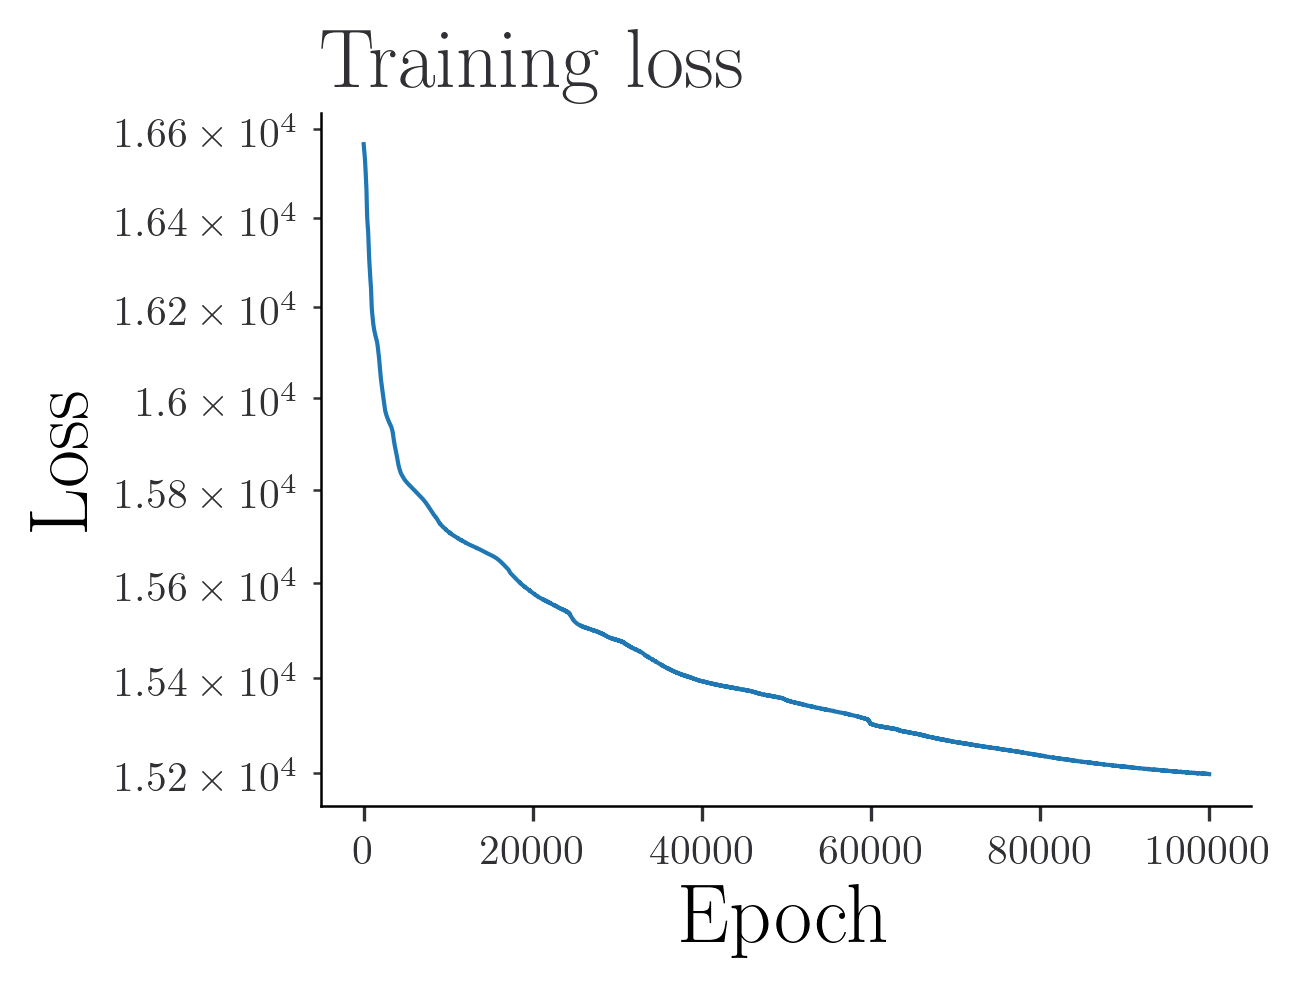

In [19]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

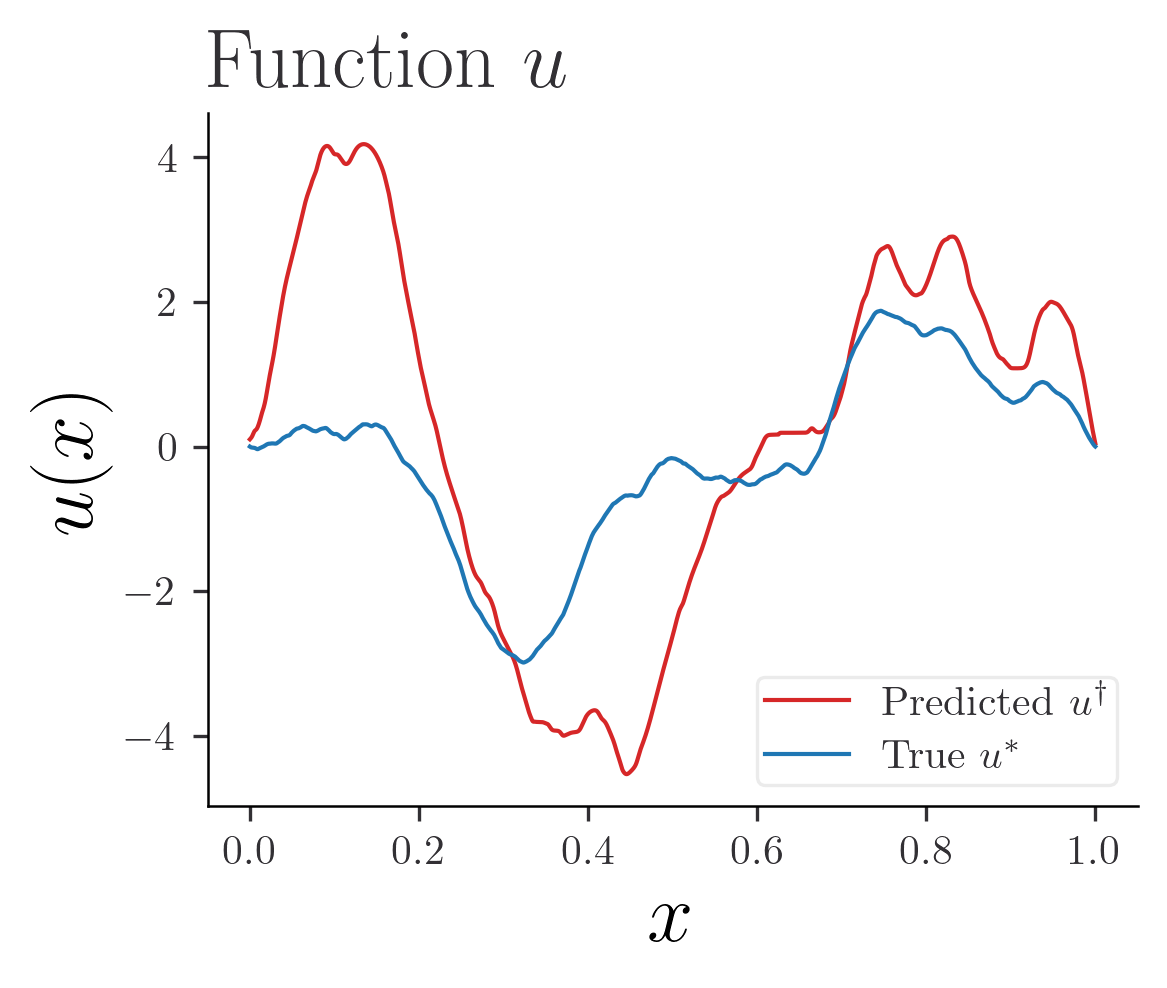

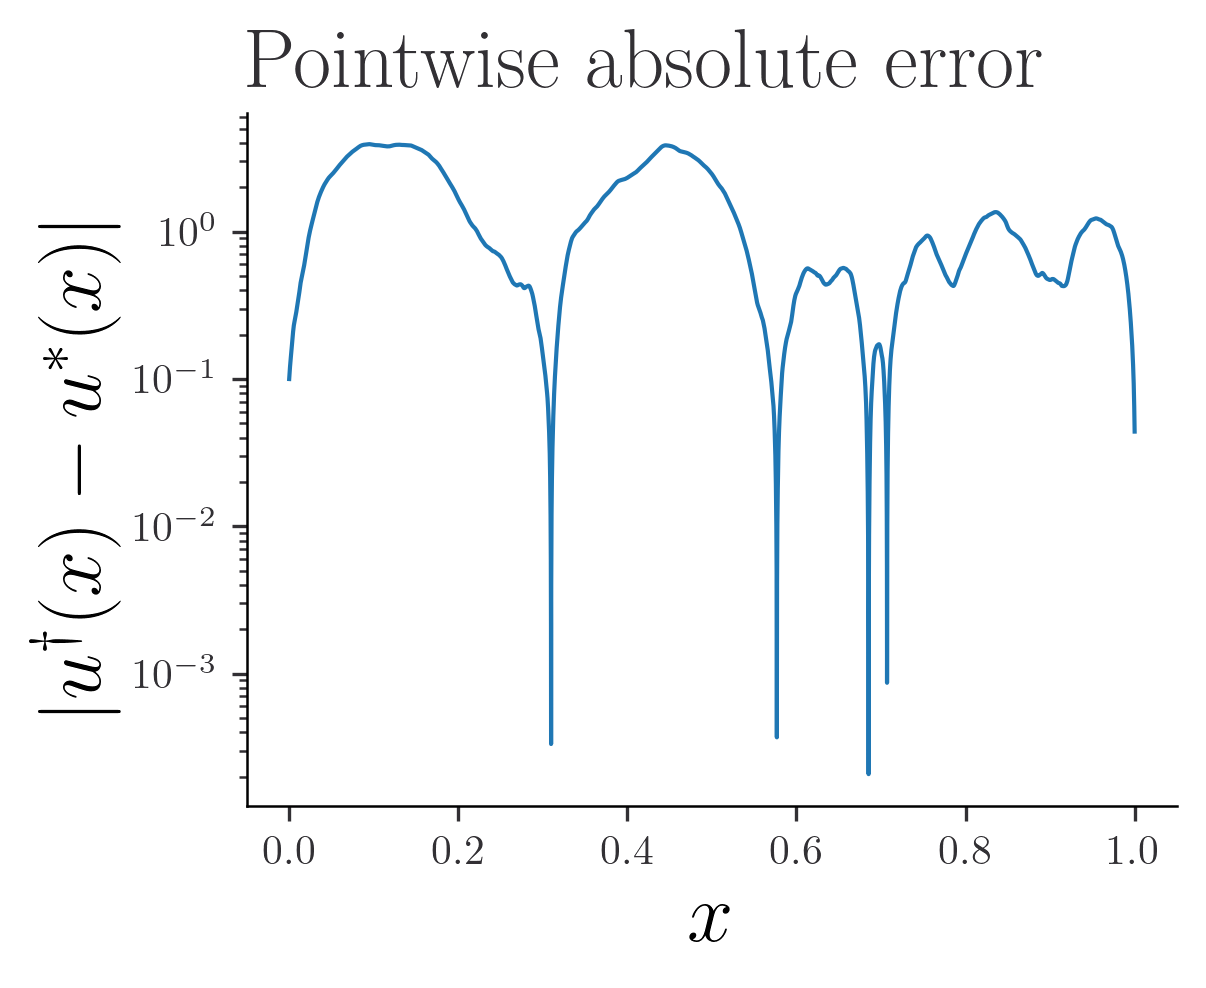

In [20]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()
